## Classifying gender using names using Logistic Regression

### Importing all the requirements

In [1]:
# For Preprocessing
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer

# For Training
from sklearn.linear_model import LogisticRegression

# For Validating
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, mean_squared_error, mean_absolute_error, r2_score

# For Visualization
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import ListedColormap
import pylab as pl

# MLFLOW

import mlflow
import mlflow.sklearn

### Userdefined functions

In [7]:
def get_features(data):
    pass

def scatter_plot(X_data, y_data, title="Classification Plot", legend_1='legend-1', legend_2='legend-2', color_1='#76aad3', color_2='#5439a4'):
    X = X_data
    y = y_data
    
    
    pca = PCA(n_components=2).fit(X)
    pca_2d = pca.transform(X)

    for i in range(0, pca_2d.shape[0]):
        if y[i] == 1:
            c1 = pl.scatter(pca_2d[i,0], pca_2d[i,1], c=color_1, marker='o')
        elif y[i] == 0:
            c2 = pl.scatter(pca_2d[i,0], pca_2d[i,1], c=color_2, marker='o')
    
    pl.legend([c1, c2], [legend_1, legend_2])
    pl.title(title)
    pl.figure(figsize=(40,20))
    pl.show()

def eval_metrics(actual, pred, model_type="classifier"):
    if model_type == "regression":
        rmse = np.sqrt(mean_squared_error(actual, pred))
        mae = mean_absolute_error(actual, pred)
        r2 = r2_score(actual, pred)
        
    elif model_type == "classifier":
        accuracy = accuracy_score(actual, pred)
        precision = precision_score(actual,pred)
        recall = recall_score(actual,pred)
        f1 = f1_score(actual,pred)
        
        print("Accuracy: {0:.2f}%".format(accuracy*100))
        print("Precision Score: {0:.2f}%".format(precision*100))
        print("Recall Score: {0:.2f}%".format(recall*100))
        print("F1 Score: {0:f}".format(f1))
        
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)

### Data Preprocessing

In [20]:
data = pd.read_csv("indian_name_dataset.csv")
le = preprocessing.LabelEncoder()
lb = LabelBinarizer()
ohe = preprocessing.OneHotEncoder(categories='auto')

categorical = ['1-gram', '2-gram', '3-gram', 'vowel', 'sonorants']
one_hot_enc = ['vowel','last_letter_vowel','sonorants']

for header in categorical:
    data[header] = le.fit_transform(data[header].astype(str))
    
data['gender'] = lb.fit_transform(data['gender'].values)

data = data.drop(columns=['name', 'vowel'])

# print(data.head())
    
# print(data.tail(20))

X = data.iloc[:,:-1].values
y = data.iloc[:,-1:].values

feature_columns = data.loc[:, data.columns!='gender'].columns

feature_columns = '| '+' | '.join(feature_columns) + ' |'

mlflow.log_param("features_used", feature_columns)

# print(feature_columns)

###############################
# One Hot Encoding gone wrong #
###############################

# ohe.fit(data[['vowel','last_letter_vowel','sonorants']])
# ohe_data = ohe.transform(data[['vowel','last_letter_vowel','sonorants']]).toarray()

# enc_data = pd.DataFrame(ohe_data)

# print("ENC DATA")
# print(enc_data.head(20))

# data = pd.concat([data.drop(one_hot_enc+['name'], axis=1), enc_data])

# data.head(20)

###############################

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0, stratify=y)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Training and Testing the model

In [12]:
# Fitting Naive Bayes to the Training set
classifier = LogisticRegression(random_state = 0, solver='lbfgs')
classifier.fit(X_train, y_train.ravel())

# Predicting the Test set results
y_pred = classifier.predict(X_test)

eval_metrics(y_test, y_pred)

Accuracy: 83.31%
Precision Score: 95.08%
Recall Score: 74.36%
F1 Score: 0.834532


### Validating

Accuracy: 83.31%
Precision Score: 95.08%
Recall Score: 74.36%
F1 Score: 0.834532

confusion Matrix: 


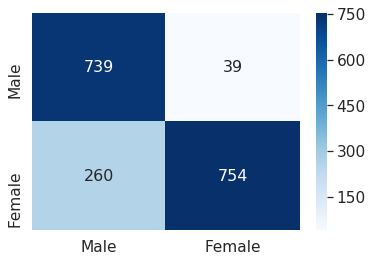

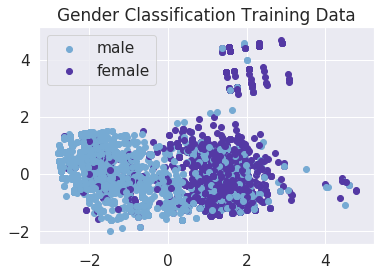

<Figure size 2880x1440 with 0 Axes>

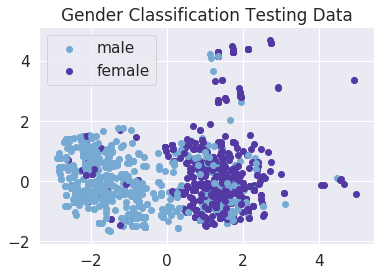

<Figure size 2880x1440 with 0 Axes>

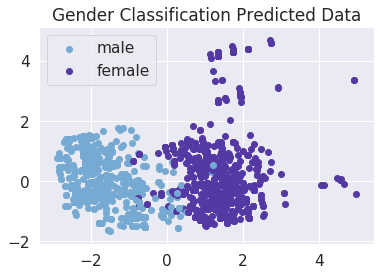

<Figure size 2880x1440 with 0 Axes>

In [13]:
cm = confusion_matrix(y_test, y_pred)

eval_metrics(y_test, y_pred, model_type="classifier")

df_cm = pd.DataFrame(cm, index=['Male', 'Female'], columns=['Male', 'Female'])
# plt.figure(figsize = (10,7))
print("\nconfusion Matrix: ")
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}, cmap='Blues', fmt='g')
plt.show()

scatter_plot(X_train, y_train, 'Gender Classification Training Data', 'male', 'female')
scatter_plot(X_test, y_test, 'Gender Classification Testing Data', 'male', 'female')
scatter_plot(X_test, y_pred, 'Gender Classification Predicted Data', 'male', 'female')
mlflow.sklearn.log_model(classifier, "model")